<a href="https://colab.research.google.com/github/jamespan1118/Xenopus_signal_processing/blob/main/Frog_calling_separation_pipline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install librosa
import librosa
from librosa import display
from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np
import scipy
import csv
import random
from scipy import fftpack
from scipy.ndimage import gaussian_filter1d
from scipy.io.wavfile import write
from scipy.fft import fft, fftfreq, rfft, rfftfreq, irfft

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def clear_out(lower,upper,data,points_per_freq):
  target_idx_noise_lower = int(points_per_freq * lower)
  target_idx_noise_upper = int(points_per_freq * upper)
  data[: target_idx_noise_lower] = 0
  data[target_idx_noise_upper:] = 0

In [ ]:
def male_female_call_separation(file_path,file_name):
  #load audio file
  samples, sampling_rate = librosa.load(file_path,sr=44100)
  #fourier transform on audio file
  yf = rfft(samples)
  xf = rfftfreq(len(samples), 1 / sampling_rate)
  #rough clean of data for smoothing
  points_per_freq = len(xf) / (sampling_rate / 2)
  target_idx_noise_150 = int(points_per_freq * 150)
  target_idx_noise_3000 = int(points_per_freq * 3000)
  yf[: target_idx_noise_150] = 0
  yf[target_idx_noise_3000:] = 0
  #sample down audio file to 23274 data points
  random_point_number = int(len(samples) * 0.001)
  randomlist = random.sample(list(range(0,(len(xf)-1))),23274)
  randomlist.sort()
  randomlist_xf = xf[randomlist]
  randomlist_yf = np.abs(yf)[randomlist]

  #smooth the curve
  #We get a smoother curve upon increasing the value of sigma.
  y_smoothed = gaussian_filter1d(randomlist_yf, sigma=40)
  peaks, _  = scipy.signal.find_peaks(y_smoothed)
  troughs, _  = scipy.signal.find_peaks(-y_smoothed)

  #data processing on the peaks and troughs
  #remove all peaks with xf value below 450, between 700 and 1600, and above 2500
  for i in peaks:
    if((randomlist_xf[i]<450) or
      ((randomlist_xf[i]>700) and (randomlist_xf[i]<1600))or
      (randomlist_xf[i]>2500)):
      peaks = np.delete(peaks,np.argwhere(peaks == i))

  #if the smallest trough that's below 450 is below 350  replace it with 350
  if(randomlist_xf[troughs].min()<350):
    troughs_list = np.where(randomlist_xf[troughs]<350,350,randomlist_xf[troughs])
  else:
    troughs_list = np.append([350], randomlist_xf[troughs], axis = 0)

  #getting the boundaries for the female call
  peak_list = randomlist_xf[peaks]
  i = 0
  while(troughs_list[i] < peak_list[0]):
    i+=1
  upper_bound_0 = troughs_list[i]
  lower_bound_0 = troughs_list[i-1]

  #getting the boundaries for the male call
  while(troughs_list[i] < peak_list[1]):
    i+=1
  upper_bound_1 = troughs_list[i]
  #the lower bound of the male call: take the 
  #difference between the upper bound and the peak,
  #and use the peak value to subtract the difference
  difference = upper_bound_1 - peak_list[1]
  lower_bound_1 = peak_list[1] - difference
  #the lower bound of male call can't go below 1500Hz for
  #Xenopus Laevis or Xenopus Petersii
  if(lower_bound_1 < 1500):
    lower_bound_1 = 1500
  
  #plot the graph
  boundary_list = [150,lower_bound_0,upper_bound_0,lower_bound_1,3000]
  plt.figure(figsize=(20,5))
  plt.plot(xf,np.abs(yf),color="grey")
  plt.plot(randomlist_xf,y_smoothed,color="red")
  plt.plot(randomlist_xf[peaks],y_smoothed[peaks],"x")
  plt.plot(randomlist_xf[troughs],y_smoothed[troughs],"o",color="green")
  plt.vlines(boundary_list,-10,3000,colors='black', linestyles='dashed')
  ticks = np.concatenate([np.arange(0, 4000, step=1000),boundary_list])
  ticks.sort()
  plt.xticks(ticks)
  plt.xlim((0,4000))
  plt.savefig(file_name + '.png')
  plt.show()

  #write boundaries to csv
  header = ['noise_lower', 'noise_higher', 'female_lower', 'female_higher','male_lower','male_higher']
  data = [boundary_list[0], 350, boundary_list[1], boundary_list[2],
          boundary_list[3],boundary_list[4]]
  with open(file_name+'.csv', 'w', encoding='UTF8') as f:
      writer = csv.writer(f)
      writer.writerow(header)
      writer.writerow(data)

  #getting the noise
  yf_noise = rfft(samples)
  clear_out(boundary_list[0],350,yf_noise,points_per_freq)
  new_sig_noise = irfft(yf_noise)
  write(file_name+'_noise.wav', sampling_rate, new_sig_noise)

  #getting the female
  yf_female = rfft(samples)
  clear_out(boundary_list[1],boundary_list[2],yf_female,points_per_freq)
  new_sig_female = irfft(yf_female)
  write(file_name+'_female.wav', sampling_rate, new_sig_female)

  #getting the male
  yf_male = rfft(samples)
  clear_out(boundary_list[3],boundary_list[4],yf_male,points_per_freq)
  new_sig_male = irfft(yf_male)
  write(file_name+'_male.wav', sampling_rate, new_sig_male)

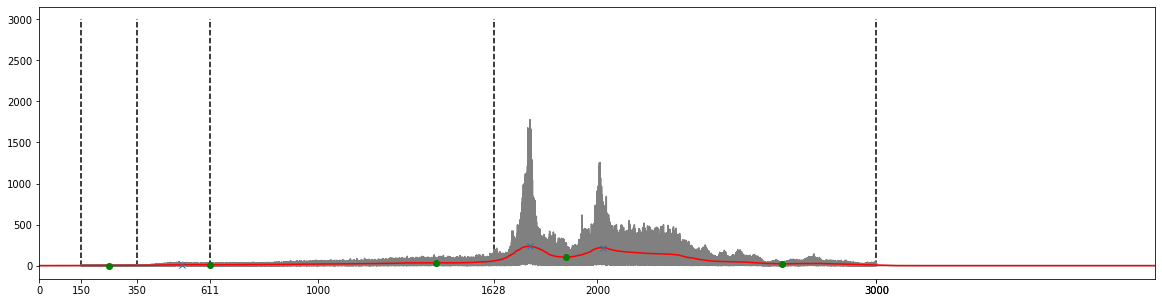

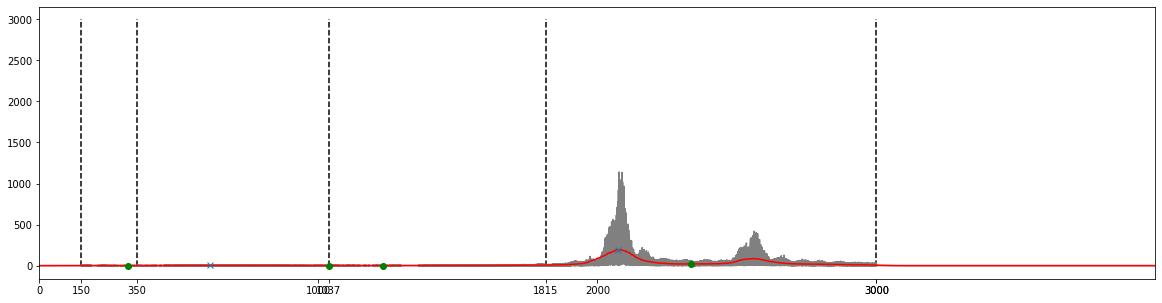

In [ ]:
male_female_call_separation('/content/01-F818D-F8387-220616_0456_8min_selection (1).wav','01-F818D-F8387-220616_0456_8min_selection (1)')
male_female_call_separation('/content/02-F8212-F829D-220617_0244_2min_selection.wav','02-F8212-F829D-220617_0244_2min_selection')

In [ ]:
!git init Female_Male_Vocalization

Initialized empty Git repository in /content/Female_Male_Vocalization/.git/


In [ ]:
!git status

fatal: not a git repository (or any of the parent directories): .git
